# A script for assigning boolean value to 'it is night time'

## Jason Kniss
### Feb 22 2024

Import libraries

In [1]:
# Import libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

Import data

In [2]:
# Optionally declare Lat and Long for stationary sites
lat = 79.983 # North(+)
long = 85.95 # West(+)

# Using a sample Eureka .txt file with a time stamp
tower_hrly = 'data/eureka-data/tower-met/eurmeteorologicaltwr.b1.20110701.000000.txt' # Tower meteorological data for July 01 2011

with open(tower_hrly, "r") as f:
    lines = f.readlines()

header = lines[0].strip().split()
data_rows = [line.strip().split("\t") for line in lines[1:]]
df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

df = df.astype('float')
df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 

# Note, I'd prefer to have this change the 2400 HourMin to 0000 the following day, but I wasn't able to figure that out.

In [3]:
df.head()

,DayFrac,Year,JulianDay,HourMin,Pressure[mbar],10MVTair[degC],10MRH[%],6MVTair[degC],6MRH[%],2MVTair[degC],...,2MTair[degC],10MTCETair[degC],6MTCETair[degC],6MTCWTair[degC],2MTCWTair[degC],Wdir[deg],Wspd[m/s],HumidityQC,AirTempQC,TCAirTempQC
0,182.000,2011.0,182.0,0.0,1006.3,18.695,22.882,18.781,23.215,18.933,...,18.346,19.155,19.320,19.481,-9999.0,176.99,2.6605,0.0,0.0,1.0
1,182.001,2011.0,182.0,1.0,1006.4,18.719,23.086,18.856,23.790,18.990,...,18.392,19.351,19.578,19.562,-9999.0,195.14,1.9895,0.0,0.0,1.0
2,182.001,2011.0,182.0,2.0,1006.4,18.802,23.171,18.892,23.560,19.018,...,18.406,19.430,19.517,19.658,-9999.0,180.96,2.0947,0.0,0.0,1.0
3,182.002,2011.0,182.0,3.0,1006.4,18.793,22.865,18.861,23.263,18.985,...,18.389,19.124,19.244,19.377,-9999.0,165.34,2.3053,0.0,0.0,1.0
4,182.003,2011.0,182.0,4.0,1006.4,18.691,22.890,18.768,23.457,18.933,...,18.341,19.227,19.421,19.453,-9999.0,160.13,2.1737,0.0,0.0,1.0


### 1) Determine declination

define sin/cos functions that expect degrees as the input

In [4]:
def cosd(degrees):
     return np.cos(np.deg2rad(degrees))
def sind(degrees):
    return np.sin(np.deg2rad(degrees))

There are two equations to calculate declination (Duffie, 2013). The first is slightly more accurate so we will use it. However the second is simpler and generally considered close enough for most engineering applications.

In [5]:
df['B'] = (df['JulianDay'] - 1)*(360/365)
df['decl'] = (180/np.pi)*(0.006918 - 0.399912*cosd(df['B']) + 0.070257*sind(df['B']) - 0.006785*cosd(2*df['B']) + 0.000907*sind(2*df['B']) - 0.002697*cosd(3*df['B']) + 0.00148*sind(3*df['B']))
# df['decl'] = 23.45*sind(360*(284 + df['JulianDay'])/365) # Less accurate but typically adequate for most engineering purposes

### 2) Determine hour angle

2a) determine local time in terms of minutes from *solar* noon (+ afternoon, - morning)

**Eureka data is logged as GMT/UTC time**

In [6]:
df['E'] = 229.2*(0.000075 + 0.001868*cosd(df['B']) - 0.032077*sind(df['B']) - 0.014615*cosd(2*df['B']) - 0.04089*sind(2*df['B']))

df['t_corr'] = 4*(0-long) + df['E'] 

In [7]:
def time_to_minutes(time_float):
    # Convert float to string and then to HHMM format
    time_str = str(int(time_float)).zfill(4)
    # Convert HHMM string to minutes
    hours = int(time_str[:2])
    minutes = int(time_str[2:])
    return hours * 60 + minutes

def minutes_from_noon(time_float):
    # Calculate the difference between the time and noon (720 minutes)
    time_minutes = time_to_minutes(time_float)
    minutes_difference = time_minutes - 720
    return minutes_difference

# Apply the minutes_from_noon function to the 'HourMin' column
df['MinutesFromNoon'] = df['HourMin'].apply(minutes_from_noon)

Calculate solar (local) time

In [8]:
df['t_sol'] = round(df['MinutesFromNoon'] + df['t_corr'])

In [9]:
def minutes_to_HourMin(minutes):
    # Calculate hours and minutes
    hours = int(minutes) // 60 + 12
    if hours < 0:
        hours += 24
    minutes = int(minutes) % 60

    # Format the time as HHMM
    return '{:02d}{:02d}'.format(hours, minutes)

df['local_time'] = df['t_sol'].apply(minutes_to_HourMin)

Calculate hour angle

In [10]:
df['w'] = df['t_sol'] * (360/1440)

### 3) Calculate zenith angle

Zenith angle is the angle between the verticle to the sun. It is the compliment of the altitude angle, which represents the angle between the sun and the horizon.

In [11]:
df['theta_z'] =  np.degrees(np.arccos(cosd(lat) * cosd(df['decl']) * cosd(df['w']) + sind(lat) * sind(df['decl'])))

In [12]:
print(min(df['theta_z']))
print(max(df['theta_z']))

56.80735648231765
76.84135648231764


### 4) Determine whether it is night based on the zenith angle

We will define 'night' as when the sun is 15 degrees or more below the horizon, or when zenith angle exceeds 105

In [13]:
df['isnight'] = (df['theta_z'] > 105)

In [14]:
df.head()

,DayFrac,Year,JulianDay,HourMin,Pressure[mbar],10MVTair[degC],10MRH[%],6MVTair[degC],6MRH[%],2MVTair[degC],...,B,decl,E,t_corr,MinutesFromNoon,t_sol,local_time,w,theta_z,isnight
0,182.000,2011.0,182.0,0.0,1006.3,18.695,22.882,18.781,23.215,18.933,...,178.520548,23.175644,-3.462145,-347.262145,-720,-1067.0,1813,-266.75,67.760033,False
1,182.001,2011.0,182.0,1.0,1006.4,18.719,23.086,18.856,23.790,18.990,...,178.520548,23.175644,-3.462145,-347.262145,-719,-1066.0,1814,-266.50,67.803141,False
2,182.001,2011.0,182.0,2.0,1006.4,18.802,23.171,18.892,23.560,19.018,...,178.520548,23.175644,-3.462145,-347.262145,-718,-1065.0,1815,-266.25,67.846223,False
3,182.002,2011.0,182.0,3.0,1006.4,18.793,22.865,18.861,23.263,18.985,...,178.520548,23.175644,-3.462145,-347.262145,-717,-1064.0,1816,-266.00,67.889281,False
4,182.003,2011.0,182.0,4.0,1006.4,18.691,22.890,18.768,23.457,18.933,...,178.520548,23.175644,-3.462145,-347.262145,-716,-1063.0,1817,-265.75,67.932311,False


Print the dataset to excel to view entirely

In [15]:
# file_name = 'printed-isnight.xlsx'
# df.to_excel(file_name, index=False)

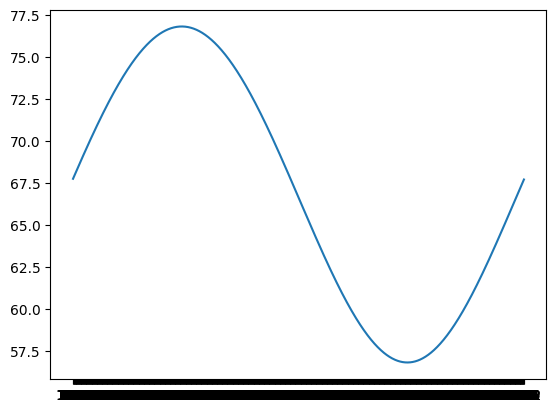

In [16]:
plt.plot(df['local_time'], df['theta_z'])